<a href="https://colab.research.google.com/github/nidhihegde001/ML4SCI/blob/main/CosmicRayImages/Hackathon_CR_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hackathon - Cosmic Ray Detection

### Problem  Statement

- CCD-based cameras are used extensively in exploration satellites and space telescopes for imaging the surfaces of celestial bodies, and deep-space objects such as stars, extrasolar systems, and galaxies. 

- These sensors are often subjected to constant irradiation by galactic cosmic rays. The interaction of these ionizing radiations with optical sensors leads to confusion and loss of imaging pixels (an ‘artifact’).
<!-- -Identification of these artifacts can help in effective filtering of data.
Besides, identifying cosmic-ray events in images, and classifying their nature and frequency opens a new path for studying cosmic-ray events throughout the solar system. -->
- Your goal is to develop a model which automatically locates cosmic ray artifacts by creating bounding boxes around them
 

In [16]:
from PIL import Image
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7,7)

In [3]:
im1 = Image.open('sample_cosmic_ray.JPG')
im2 = Image.open('EW0220137668G.IMG.jpg')

Here is an example of a cosmic ray artifact in an image: <br>

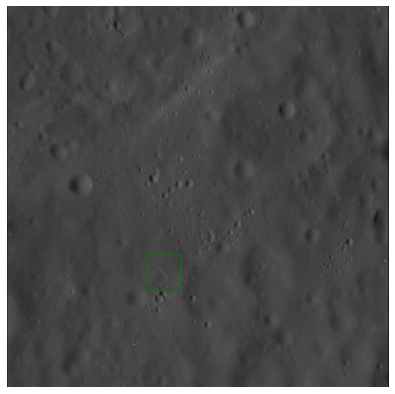

In [17]:
plt.imshow(im1, cmap = 'gray')
plt.axis('off')
plt.show()

Just as a fun exercise to help you appreciate the problem,
try locating the cosmic ray artifact in the image below <br>

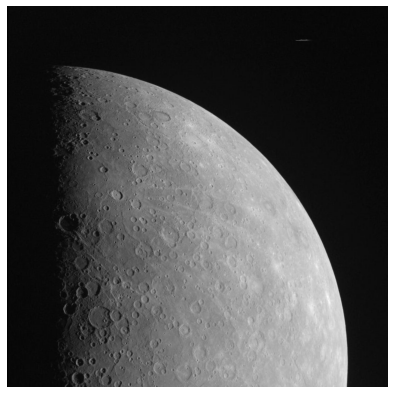

In [19]:
plt.imshow(im2, cmap = 'gray')
plt.axis('off')
plt.show()

### Dataset
The dataset for the problem can be accessed in the following link:
https://drive.google.com/drive/folders/1p6m9Do5d2qr51TWxW1xpVNQnd8Lq7uic?usp=sharing 

Divide it into train and valid splits based on your preference and finally form your folder structure as below:

----------------------
    Provide path to dataset
    Format: PascalVOC

                root
         /     /            \      \ 
    train train_annots  valid  valid_annots

  -----------------------------


- **The size of the dataset is what makes the problem interesting!**<br>
You don't have a lot of data, thus your goal is to maximize learning on this scarce data.<br>
Wonder how you can leverage your Deep learning skills to obtain decent results for the problem!
<br>

Some pointers to help you: <br>
1. Browse about existing techniques like few shot learning, and how they are used when the size of datasets is small.
2. Try to learn about object detectors based on backbones like ResNet, which may be efficient in locating small objects.

Feel free to come up with other interesting ideas!

### A sample detector:
Below is an example of training an object detector called 'Region Proposal Network' (RPN) on this data

In [1]:
from PIL import Image
import numpy as np
from numpy import asarray
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import time
import os
import copy
from torchvision.datasets.voc import VisionDataset
import torch.nn.functional as F
import math
import torch.utils.model_zoo as model_zoo

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/My Drive/CRISMIS/roboflow_156_voc.zip'

In [5]:
def generate_anchors(target): # data is the training set

  gt_bbox = np.array(target[0],dtype=np.float32)
  gt_labels = np.array(target[1])
  anchor_areas = [ x**2 for x in [16.0, 32.0, 64.0]]
  ratios = [0.5, 1, 2]
  anchor_scales = [1]
  fe_size = 32
  anchors = np.zeros((len(anchor_areas)*len(ratios)*len(anchor_scales)*fe_size*fe_size, 4),dtype=np.float32)
  ctr =  np.zeros((fe_size*fe_size, 2),dtype=np.float32)
  pts = np.arange(1024/fe_size-1, 1024, 1024/fe_size)
  index = 0
  for x in range(len(pts)):
      for y in range(len(pts)):
          ctr[index, 0] = pts[x] - 1024/(fe_size*2)
          ctr[index, 1] = pts[y] - 1024/(fe_size*2)
          index +=1

  # Code to generate anchors at a location in Fmap
  index = 0
  for c in ctr:
    ctr_y, ctr_x = c
    for i in range(len(ratios)):
      for j in range(len(anchor_scales)):
        for k in range(len(anchor_areas)):
          h = anchor_scales[j] * np.sqrt(anchor_areas[k]/ratios[i])
          w = anchor_scales[j] * (anchor_areas[k]/h)
          anchors[index, 0] = ctr_y - h / 2.
          anchors[index, 1] = ctr_x - w / 2.
          anchors[index, 2] = ctr_y + h / 2.
          anchors[index, 3] = ctr_x + w / 2.
          index += 1
  valid_anchors = anchors
  valid_anchors[:, slice(0, 4, 2)] = np.clip(
              anchors[:, slice(0, 4, 2)], 0, 1024)
  valid_anchors[:, slice(1, 4, 2)] = np.clip(
      anchors[:, slice(1, 4, 2)], 0, 1024)
  # Create labels and anchors for valid anchor boxes
  label = np.empty((len(valid_anchors), ), dtype=np.int32)
  # default initialisation
  label.fill(-1)

  if (len(gt_labels)==0):
    anchor_locations = np.empty((len(anchors),) + anchors.shape[1:], dtype=anchors.dtype)
    anchor_locations.fill(0)
    return label,anchor_locations
  ious = np.empty((len(valid_anchors), len(gt_labels)), dtype=np.float32)
  ious.fill(0)

# Calculating iou
  for num1, i in enumerate(valid_anchors):
      ya1, xa1, ya2, xa2 = i  
      anchor_area = (ya2 - ya1) * (xa2 - xa1)
      for num2, j in enumerate(gt_bbox):
          yb1, xb1, yb2, xb2 = j
          box_area = (yb2- yb1) * (xb2 - xb1)
          inter_x1 = max([xb1, xa1])
          inter_y1 = max([yb1, ya1])
          inter_x2 = min([xb2, xa2])
          inter_y2 = min([yb2, ya2])
          if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
              iter_area = (inter_y2 - inter_y1)*(inter_x2 - inter_x1)
              iou = iter_area/(anchor_area+ box_area - iter_area)            
          else:
              iou = 0
          ious[num1, num2] = iou

  gt_argmax_ious = ious.argmax(axis=0)
  gt_max_ious = ious[gt_argmax_ious, np.arange(ious.shape[1])]
  argmax_ious = ious.argmax(axis=1)
  max_ious = ious[np.arange(len(label)), argmax_ious]

  # LABELLING GT ANCHORS
  pos_iou_threshold  = 0.5
  neg_iou_threshold = 0.05
  label[max_ious < neg_iou_threshold] = 0
  label[gt_argmax_ious] = 1
  label[max_ious >= pos_iou_threshold] = 1

  # Creating 256 training samples,half positive, half negative
  # pos_ratio = 0.5
  n_neg = 1024
  pos_index = np.where(label==1)[0]
  neg_index = np.where(label == 0)[0]
  if len(neg_index) > n_neg:
      disable_index = np.random.choice(neg_index, size=(len(neg_index) - n_neg), replace = False)
      label[disable_index] = -1

  final_neg_anchor_indices = np.where(label==0)[0]
  final_neg_anchors = valid_anchors[final_neg_anchor_indices]
# get the most probable gt_bbox at each valid anchor location 
  max_iou_bbox = gt_bbox[argmax_ious]

  height = valid_anchors[:, 2] - valid_anchors[:, 0]
  width = valid_anchors[:, 3] - valid_anchors[:, 1]
  ctr_y = valid_anchors[:, 0] + 0.5 * height
  ctr_x = valid_anchors[:, 1] + 0.5 * width
  base_height = max_iou_bbox[:, 2] - max_iou_bbox[:, 0]
  base_width = max_iou_bbox[:, 3] - max_iou_bbox[:, 1]
  base_ctr_y = max_iou_bbox[:, 0] + 0.5 * base_height
  base_ctr_x = max_iou_bbox[:, 1] + 0.5 * base_width
  eps = np.finfo(height.dtype).eps
  height = np.maximum(height, eps)
  width = np.maximum(width, eps)
  dy = (base_ctr_y - ctr_y) / height
  dx = (base_ctr_x - ctr_x) / width
  dh = np.log(base_height / height)
  dw = np.log(base_width / width)
  anchor_locs = np.vstack((dy, dx, dh, dw)).transpose()
  anchor_locations = np.empty((len(anchors),) + anchors.shape[1:], dtype=anchor_locs.dtype)
  anchor_locations.fill(0)
  anchor_locations = anchor_locs
  # print(label.shape,anchor_locations.shape)
  return label,anchor_locations
  

In [6]:
# data loader
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'valid': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}
class Cosmic_Detection(VisionDataset):
  def __init__(self,
                root,                 
                mode='train',
                transform=None,
                target_transform=None,
                transforms=None):
      super(Cosmic_Detection, self).__init__(root, transforms, transform, target_transform)

      voc_root = 'roboflow_156_voc'  # Name of your dataset folder 
      image_dir = os.path.join(voc_root, mode)
      annotation_dir = os.path.join(voc_root, mode +'_annots')

      if not os.path.isdir(voc_root):
          raise RuntimeError('Dataset not found or corrupted')

      file_names = []
      for f in os.listdir(image_dir):
        file_names.append(f[:-4])
      self.images = [os.path.join(image_dir, x + ".jpg") for x in file_names]
      self.annotations = [os.path.join(annotation_dir, x + ".xml") for x in file_names]
      assert (len(self.images) == len(self.annotations))

  def __getitem__(self, index):
      img = Image.open(self.images[index]).convert('RGB')
      target = self.parse_voc_xml(ET.parse(self.annotations[index]).getroot())

      if self.transforms is not None:
          img, target = self.transforms(img, target)

      labels, locations = generate_anchors(target)

      return img.view(1,3,1024,1024), labels, locations


  def __len__(self):
      return len(self.images)

    
  def parse_voc_xml(self, root):
        # extract each bounding box
        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [ymin, xmin, ymax, xmax]
            boxes.append(coors)
        # extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        # extract all the classes
        labels = list()
        for category in root.findall('.//name'):
          labels.append(category.text)
        return boxes, labels

In [7]:
dataset = {x: Cosmic_Detection(None, x, data_transforms[x]) 
                  for x in ['train', 'valid']}

dataloaders = {x: torch.utils.data.DataLoader(dataset[x], batch_size=1,
                                             shuffle=True, num_workers=4, pin_memory = True)
              for x in ['train', 'valid']}

dataset_sizes = {x: len(dataset[x]) for x in ['train', 'valid']}

In [8]:
for inputs,labels,locs in dataloaders['train']:
        print(inputs[0].shape)
        print(labels[0].shape)
        print(locs[0].shape)
        break

torch.Size([1, 3, 1024, 1024])
torch.Size([9216])
torch.Size([9216, 4])


In [10]:
VGG_model = torchvision.models.vgg16(pretrained=True)
fe = list(VGG_model.features)
mid_channels = 512
in_channels = 512 # depends on the output feature map. in vgg 16 it is equal to 512
n_anchor = 9 # Number of anchors at each location
conv1 = nn.Conv2d(in_channels, mid_channels, 3, 1, 1)
# Initialising the layer weights with values from Gaussian(0,0.01)
# conv sliding layer
conv1.weight.data.normal_(0, 0.01)
conv1.bias.data.zero_()
print(fe)

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [11]:
class Detector(nn.Module):
    def __init__(self):
        super(Detector, self).__init__()
        self.backbone = torch.nn.Sequential(*fe,conv1)
        self.reg_layer = nn.Conv2d(mid_channels, n_anchor *4, 1, 1, 0)
        self.cls_layer = nn.Conv2d(mid_channels, n_anchor *2, 1, 1, 0)
        # Regression layer
        self.reg_layer.weight.data.normal_(0, 0.01)
        self.reg_layer.bias.data.zero_()
        # classification layer
        self.cls_layer.weight.data.normal_(0, 0.01)
        self.cls_layer.bias.data.zero_()
        
    def forward(self, input_image):
        out_map = self.backbone(input_image)
        pred_cls_scores = self.cls_layer(out_map)
        pred_anchor_locs = self.reg_layer(out_map)
        return pred_cls_scores, pred_anchor_locs

In [12]:
CR_Detector = Detector().to(device)

In [13]:
def train_model(model, start_epoch = 0,num_epochs=1):
  weights = [0.05, 0.95]
  class_weights = torch.FloatTensor(weights).to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  since = time.time()
  model_wts = copy.deepcopy(model.state_dict())
  best_loss = 100.0
        
  for epoch in range(num_epochs):        
      print('Epoch {}/{}'.format(epoch + start_epoch, start_epoch+ num_epochs-1))
      print('-' * 10)

      # Each epoch has a training and validation phase
      for phase in ['train', 'valid']:
          if phase == 'train':
              model.train()  # Set model to training mode
          else:
              model.eval()   # Set model to evaluate mode
                
          cls_loss = 0.0
          reg_loss = 0.0  
          running_loss = 0.0            
          total_cls_loss = 0.0
          total_reg_loss = 0.0
          total_epoch_loss = 0.0
          index = -1

          # Iterate over data.
          for inputs, labels, locations in dataloaders[phase]:
            # Batch size 1
              index+=1
              inputs = inputs[0].to(device)
              target_labels_np = labels[0].data.numpy()
              pos_arr = np.where(target_labels_np > 0)[0]
              target_labels = labels[0].to(device)
              target_locs = locations[0].to(device)
              pos = target_labels > 0
              # zero the parameter gradients
              optimizer.zero_grad()
              # forward
              # track history if only in train
              with torch.set_grad_enabled(phase == 'train'):
                  pred_labels, pred_locs = model(inputs)
                  if torch.isnan(pred_locs ).any():
                      print("Nan in output prediction:", index)
                      return None

                  pred_labels = pred_labels.permute(0, 2, 3, 1).contiguous()
                  pred_labels = pred_labels.view(1, 32, 32, 9, 2).contiguous().view(-1, 2)
                  pred_locs = pred_locs.permute(0, 2, 3, 1).contiguous().view(-1, 4)
                  rpn_cls_loss = F.cross_entropy(pred_labels, target_labels.long(), ignore_index = -1,weight = class_weights)
                
                  if not(pos_arr.size == 0):
                      mask = pos.unsqueeze(1).expand_as(pred_locs)
                      mask_loc_preds = pred_locs[mask].view(-1,4)
                      mask_loc_targets = target_locs[mask].view(-1, 4)
                      x = torch.abs(mask_loc_targets - mask_loc_preds)
                      rpn_loc_loss = (((x < 1).float() * 0.5 * x*x) + ((x >= 1).float() * (x-0.5))).sum()
                      rpn_loc_loss_item = rpn_loc_loss.item()
                      rpn_loss = rpn_cls_loss +  rpn_loc_loss
                  else:
                      rpn_loc_loss_item = 0
                      rpn_loss = rpn_cls_loss
                  
                  # backward + optimize only if in training phase
                  if phase == 'train':
                      rpn_loss.backward()
                      optimizer.step()

              # statistics
              cls_loss += rpn_cls_loss.item()
              reg_loss += rpn_loc_loss_item
              running_loss += rpn_loss.item()
          # if phase == 'train':
          #     scheduler.step()

          total_cls_loss = cls_loss / dataset_sizes[phase]
          total_reg_loss = reg_loss / dataset_sizes[phase]
          total_epoch_loss = running_loss / dataset_sizes[phase]

          print('{} rpn_cls Loss: {:.4f}       {} rpn_reg Loss: {:.4f}       {} Total Loss: {:.4f}'.format(phase, total_cls_loss,phase, total_reg_loss,phase, total_epoch_loss))

          # deep copy the model
          if phase == 'train' and total_epoch_loss < best_loss:
              best_loss = total_epoch_loss
              model_wts = copy.deepcopy(model.state_dict())
      print()
  
  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
      time_elapsed // 60, time_elapsed % 60))
  print('Best Loss: {:4f}'.format(best_loss))

  # load model weights
  model.load_state_dict(model_wts)
  return model

In [14]:
model_1 = train_model(CR_Detector)

Epoch 0/0
----------
train rpn_cls Loss: 0.5182       train rpn_reg Loss: 0.9223       train Total Loss: 1.4404
valid rpn_cls Loss: 0.4053       valid rpn_reg Loss: 0.7235       valid Total Loss: 1.1288

Training complete in 2m 35s
Best Loss: 1.440448


### Submission Format

You need to submit the predictions of your model on the test data as follows:

- For each image in the test folder, you need to write your predictions into a corresponding ".txt" file with the same image name, following the format below:<br>
   ```Positive  <confidence> <left> <top> <right> <bottom>```
    - Class name (will be constant across all predictions)
    - Confidence score for that prediction (between 0 and 1)
    - left x co-ordinate of the box predicted (between 0 and 1024)
    - top y co-ordinate of the box predicted (between 0 and 1024)
    - right x co-ordinate of the box predicted (between 0 and 1024)
    - bottom y co-ordinate of the box predicted (between 0 and 1024)
    
- An image may contain more than 1 artifact, in which case each prediction instance is to be written on a separate line of the '.txt' file.
- Put all these '.txt' files into a single folder with the name ```predictions/``` 
- Your submission should include the ```notebook``` along with the ```predictions/``` folder. Zip them into ```<Your Team Number>.zip``` before submission.
    
    
    

